In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import math
from scipy import integrate
from numpy import diff
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amssymb}']}   # amssymb
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [3]:
def funciones(xi,y, sigma, n, h):
    psi_,eta_,psi1_,eta1_ = y
    dydxi = [h*(eta_ + sigma*xi**(3)*psi_**(n+1))*((1 - n*sigma) + (n+1)*sigma*psi_)/xi/(2*(n+1)*sigma*eta_ - xi)
           ,xi**(2)*psi_**(n)*(1 - n*sigma + n*sigma*psi_) 
           ,h*(((eta1_ + 3*sigma*xi**(2)*psi_**(n+1) + sigma*xi**(3)*(n+1)*psi_**(n)*psi1_)*((1 - n*sigma) + (n + 1)*sigma*psi_)/xi/(2*(n+1)*sigma*eta_ - xi)) + (sigma*(n+1)*psi1_)*(eta_ + sigma*xi**(3)*psi_**(n+1))/xi/(2*(n+1)*sigma*eta_ - xi)  -  (((1 - n*sigma) + (n + 1)*sigma*psi_)*(eta_ + sigma*xi**(3)*psi_**(n+1))/xi**(2)/(2*(n+1)*sigma*eta_ - xi) )  -  (((1 - n*sigma) + (n + 1)*sigma*psi_)*(eta_ + sigma*xi**(3)*psi_**(n+1))*(2*(n+1)*sigma*eta1_ - 1)/xi/((2*(n+1)*sigma*eta_ - xi)**(2))))         
           ,(2*xi*psi_**(n) + n*xi**(2)*psi_**(n-1)*psi1_)*(1 - n*sigma + n*sigma* psi_) + xi**(2)*psi_**(n)*n*sigma*psi1_]
    return dydxi

In [4]:
c = 2.997*10**(8)               # Speed of light in SI units
G = 6.673*10**(-11)             # Gravitational Constant in SI units
Msun = 1.989*10**(30)           # 1 Solar Mass in SI units

In [5]:
                                       ## Lista de parámetros ##

# C
C_inicial = 0                    # C inicial            
C_final =  1/4                   # C final
Paso_C = 1/32                    # Diferencia entre valores consecutivos
Num_C = round((Paso_C + C_final - C_inicial)/Paso_C)  # Número de valores
Lista_C = np.linspace(C_inicial,C_final,Num_C)        # Lista con valores desde C inicial hasta C final
Lista_C = [0,1/32,1/16,3/32,1/8,5/32,3/16,7/32,1/4]
print('C interval: ',end='')
print(*Lista_C, sep=', ')

# n 
n_inicial = 0.5          # n inicial 
n_final = 4.0             # n final
Paso_n = 0.5             # Diferencia entre valores consecutivos
Num_n = round((Paso_n + n_final - n_inicial)/Paso_n)  # Número de valores
Lista_n = np.linspace(n_inicial,n_final,Num_n)        # Lista con valores desde n inical hasta n final
Lista_n = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
print('n interval: ',end='')                                                    
print(*Lista_n, sep=', ')

# Sigma = razón entre Presión central y Densidad central
sigma_inicial = 0.05             # sigma inicial             
sigma_final = 0.8                # sigma final
Paso_sigma = 0.05                # Diferencia entre valores consecutivos
Num_sigma = round((Paso_sigma + sigma_final - sigma_inicial)/Paso_sigma)  # Número de valores
Lista_sigma = np.linspace(sigma_inicial,sigma_final,Num_sigma)            # Lista con valores desde sigma inical hasta sigma final
Lista_sigma = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
print('\u03c3 interval: ',end='')
print(*Lista_sigma, sep=', ')

Number_of_models = len(Lista_C)*len(Lista_n)*len(Lista_sigma)
print('Number of models: ', Number_of_models)

rho_c = 2.5*10**(18)               # Densidad central

C interval: 0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25
n interval: 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0
σ interval: 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8
Number of models:  1152


In [6]:
ListaModelos = []                                        # Container for all models 

for i in range(len(Lista_C)):
    
    ListaModelos.append([])                              # Container for n
    
    for j in range(len(Lista_n)):
        
        ListaModelos[i].append([])                       # Container for C
        
        for k in range(len(Lista_sigma)):
            
            ListaModelos[i][j].append([])                # Contenedor para sigma

In [7]:
%%time

contador = 0

for i in range(len(Lista_C)):
    
    C = Lista_C[i]
    h = 1 - 2*C
    
    for j in range(len(Lista_n)):
        
        n = Lista_n[j]
        
        for k in range(len(Lista_sigma)):
            
            sigma = Lista_sigma[k]
                    
            K = sigma*c**(2)/rho_c**(1/n)      # k**(n) en m**(3)/kg
                     
            # Condiciones iniciales
            Psi0 = 1.0
            Eta0 = 0.0
            Psi10 = 0.0
            Eta10 = 0.0
            
            y0 = [Psi0,Eta0,Psi10,Eta10]
            
            def stop_condition(xi,y,sigma,n,h):
                return y[0] - 10**-15
            
            stop_condition.terminal = True
            
            xi0 = 10**(-15)
            ximax = 10000
    
            xi_span = (xi0,ximax)
        
            soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                                   args=(sigma,n,h))
            
            if soluciones.status == 0:
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                print('Insufficient integration interval xi, please increase it. Parameters: ',
                      'C = %.3f, '%(C),'n = %.1f, '%(n),'\u03c3 = %.2f, '%(sigma))
                contador = contador + 1
                continue
                
            else:
                Psi = soluciones.y[0]
                Eta = soluciones.y[1]
                Psi1 = soluciones.y[2]
                Eta1 = soluciones.y[3]
                xi = soluciones.t
                
            
######################################################################################################################
            
                xiNorm = xi/xi[-1]                                       # xi normalized
                
                Densidad = Psi**(n)                                      # Density
                
                Dprima = n*Psi**(n-1)*Psi1                               # Density gradient
                
                PNorm = Psi**(n+1)
                
                m = (c**(2)*sigma*(n+1)/(4*np.pi*rho_c)**(1/3)/G)**(3/2)*Eta/Msun   # Masa en unidades de masa solar
                r = (c**(2)*sigma*(n+1)/4/np.pi/G/rho_c)**(1/2)*xi/1000             # Radio en kilómetros
                mr = 2*sigma*(n+1)*Eta/xi                                           # 2*G*m/c**(2)/r
                
                # Tangential pressure
                PTNorm = (C*(n+1)*(Eta + sigma*Psi**(n+1)*xi**(3))/(xi - 2*Eta*sigma*(n+1)))*(Psi**(n) + sigma*Psi**(n+1)) + Psi**(n+1)
                
                # Second derivative of Psi
                Psi11 = h*(((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*xi**(3)*(n+1)*Psi**(n)*Psi1)*(sigma*Psi + 1)/xi/(2*(n+1)*sigma*Eta - xi)) + (sigma*Psi1*(Eta + sigma*xi**(3)*Psi**(n+1))/xi/(2*(n+1)*sigma*Eta - xi)) - ((1 + sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))/xi**(2)/(2*(n+1)*sigma*Eta - xi)) - ((1 + sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))*(2*(n+1)*sigma*Eta1 - 1)/xi/((2*(n+1)*sigma*Eta - xi)**(2))))
                
                mrprima = sigma*(n+1)*(Eta1/xi - Eta/xi**(2))   # Derivada de m/r
                
                Pprima = (n+1)*Psi**(n)*Psi1
                
                # Tangential pressure gradient
                Ptprima = C*(n+1)*((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*(n+1)*xi**(3)*Psi**(n)*Psi1)*(Psi**(n) + sigma*Psi**(n+1))/(xi - 2*Eta*(n+1)*sigma) + (Eta + sigma*xi**(3)*Psi**(n+1))*(n*Psi**(n-1)*Psi1 + sigma*(n+1)*Psi**(n)*Psi1)/(xi - 2*Eta*(n+1)*sigma) - (Eta + sigma*xi**(3)*Psi**(n+1))*(Psi**(n) + sigma*Psi**(n+1))*(1 - 2*Eta1*(n+1)*sigma)/(xi - 2*Eta*(n+1)*sigma)**(2)) + (n+1)*Psi**(n)*Psi1
                
                SEC = (1/sigma)*Densidad - PNorm - 2*PTNorm               # Strong energy condition (SEC)                
                
                v2r =  sigma*(1 + 1/n)*Psi                      # Sound speed squared
                
                aux1 = 1 - sigma*n + sigma*(n+1)*Psi
                
                # Diferencia de las velocidades del sonido al cuadrado
                vDelta2 = (C*sigma*(n+1)/(xi-2*sigma*(n+1)*Eta))*((1 + sigma*(n+1)*Psi/n/aux1)*(Eta + sigma*xi**(3)*Psi**(n+1)) + Psi**(n)*aux1*(xi**(2)*Psi*(1 - sigma*n + sigma*(n+3)*Psi + sigma*(n+1)*xi*Psi1)/n/aux1/Psi1) - Psi**(n)*aux1*(Eta + sigma*xi**(3)*Psi**(n+1))*(1 - 2*sigma*(n+1)*xi**(2)*Psi**(n)*(1 - sigma*n + sigma*n*Psi))/n/Psi1/((1-sigma*n)*Psi**(n-1) + sigma*(n+1)*Psi**(n))/(xi - 2*sigma*(n+1)*Eta))
    
                # Velocidad del sonido tangencial al cuadrado
                v2t = vDelta2 + v2r
            
                Gamma = v2r*(Densidad + sigma*PNorm)/PNorm/sigma
                
                # Cracking: deltaR1: Density, deltaR2: Mass, deltaR3: Pressure, delta R4: Pressure gradient   
                deltaR1 = h*((n+1) * sigma * (Eta + xi**(3) * sigma * Psi**(n+1)) / xi / (xi - 2 * sigma * n * Eta - 2 * sigma * Eta))
                deltaR2 = h*(Psi**(n+1) * xi**(2) * sigma * (n+1) * (1 + sigma * Psi) * (1 + 2 * xi**(2) * sigma * sigma * (n+1) * Psi**(n+1)) / n / Psi1 / ((xi - 2 * Eta * sigma * n - 2 * Eta * sigma)**(2)))
                deltaR3 = h*(sigma * (n+1)**(2) * sigma * Psi * (Eta + xi**(3) * Psi**(n) + 2 * sigma * xi**(3) * Psi**(n+1)) / n / xi / (xi - 2 * sigma * n * Eta - 2 * sigma * Eta))
                deltaR4 = sigma * (n+1) * (n * Psi1**(2) + Psi * Psi11) / n / Psi1
                deltaRPolitropa = deltaR1 + deltaR2 + deltaR3 + deltaR4
                
                # Buoyancy
                Psin11 = n*(Psi**(n-1)*Psi11 + (n-1)*Psi**(n-2)*Psi1**(2))
                
                M = (c**(2)*(n+1)/(4*np.pi)**(1/3)/G)**(3/2)*(k/c**(2))**(n/2)*sigma**((3-n)/2)*Eta[-1]/Msun  # Masa en unidades de masa solar
                
                R = (c**(2)*(n+1)/4/np.pi/G)**(1/2)*(k/c**(2))**(n/2)*sigma**((1-n)/2)*xi[-1]/1000         # Radio en kilómetros
                
                ##########################################################################################################
                
                # Conditions C1a, C1b and C1c
                
                if any(mr >= 1):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
                
                # Condition C2
                
                if any(Densidad < 0) or any(PNorm < 0) or any(PTNorm < 0):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
                
                # Condition C3
                
                if any(Dprima > 0) or any (Pprima > 0) or any (Ptprima[250:] > 0):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
                
    
                # Condition C4
                
                if any(SEC < 0):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
                
                # Condition C5
                
                if any(v2r > 1) or any(v2t > 1):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
                
                # Condition C6
                
                if any(Gamma < 4/3):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
                
                # Condition C7                        
                
                if n == 1.0 :
                    
                    if C == 1/4 and (sigma >= 0.25 or sigma <= 0.325) :
                        ListaModelos[i][j][k].append(1)
                    else:
                        pass
                        
                
                elif n == 1.5 :
                    
                    if C == 7/32  and (sigma >= 0.125 or sigma <= 0.225) :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 1/4 and (sigma >= 0.1 or sigma <= 0.25) :
                        ListaModelos[i][j][k].append(1)
                    
                    else:
                        pass
                        
                
                elif n == 2.0 :
                        
                    if C == 1/8 and (sigma >= 0.1 or sigma <= 0.15) :
                        ListaModelos[i][j][k].append(1)
                        
                    elif C == 5/32 and sigma <= 0.15 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 3/16 and sigma <= 0.175 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 7/32  and sigma <= 0.175 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 1/4 and sigma <= 0.175 :
                        ListaModelos[i][j][k].append(1)
                        
                    else:
                        pass
                        
                
                elif n == 2.5 :
                
                    if C == 0 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                
                    elif C == 1/32 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 1/16 and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 3/32 and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                        
                    elif C == 1/8 and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                        
                    elif C == 5/32 and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 3/16 and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 7/32  and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 1/4 and sigma <= 0.125 :
                        ListaModelos[i][j][k].append(1)
                        
                    else:
                        pass
                        
                
                elif n == 3.0 :
                
                    if C == 0 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                
                    elif C == 1/32 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 1/16 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 3/32 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                        
                    elif C == 1/8 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                        
                    elif C == 5/32 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 3/16 and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 7/32  and sigma <= 0.1 :
                        ListaModelos[i][j][k].append(1)
                    
                    elif C == 1/4 and sigma < 0.1 :
                        ListaModelos[i][j][k].append(1)
                        
                    else:
                        pass
                    
                elif n == 3.5 :
                    ListaModelos[i][j][k].append(1)
                
                
                elif n == 4.0 :
                    ListaModelos[i][j][k].append(1)
                
                else:
                    pass
                        
                
                # Condition C8
               
                if any(np.diff(np.sign(deltaRPolitropa[1:])) != 0):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass
    
                # Condition C9
                
                if any(Psin11 > 0):
                    ListaModelos[i][j][k].append(1)
                else:
                    pass            

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in subtract
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero

Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 1.5,  σ = 0.70, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 1.5,  σ = 0.75, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 1.5,  σ = 0.80, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 2.0,  σ = 0.50, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 2.0,  σ = 0.55, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 2.0,  σ = 0.60, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 2.0,  σ = 0.65, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 2.0,  σ = 0.70, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.000,  n = 2.0,  σ = 0.75, 
Insufficient integration interval xi, please increase it. Parame

Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.25, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.30, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.35, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.40, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.45, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.50, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.55, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.60, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.031,  n = 3.5,  σ = 0.65, 
Insufficient integration interval xi, please increase it. Parame

Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 1.5,  σ = 0.70, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 1.5,  σ = 0.75, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 1.5,  σ = 0.80, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 2.0,  σ = 0.50, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 2.0,  σ = 0.55, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 2.0,  σ = 0.60, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 2.0,  σ = 0.65, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 2.0,  σ = 0.70, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.094,  n = 2.0,  σ = 0.75, 
Insufficient integration interval xi, please increase it. Parame

Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.25, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.30, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.35, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.40, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.45, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.50, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.55, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.60, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.125,  n = 3.5,  σ = 0.65, 
Insufficient integration interval xi, please increase it. Parame

Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 1.5,  σ = 0.70, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 1.5,  σ = 0.75, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 1.5,  σ = 0.80, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 2.0,  σ = 0.50, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 2.0,  σ = 0.55, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 2.0,  σ = 0.60, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 2.0,  σ = 0.65, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 2.0,  σ = 0.70, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.188,  n = 2.0,  σ = 0.75, 
Insufficient integration interval xi, please increase it. Parame

Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.10, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.20, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.25, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.30, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.35, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.40, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.45, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.50, 
Insufficient integration interval xi, please increase it. Parameters:  C = 0.219,  n = 3.5,  σ = 0.55, 
Insufficient integration interval xi, please increase it. Parame

In [8]:
print(contador, ' out of ', Number_of_models, ' are NOT integrable')

515  out of  1152  are NOT integrable


In [9]:
C_List0 = []
n_List0 = []
sigma_List0 = []

C_List1 = []
n_List1 = []
sigma_List1 = []

C_List2 = []
n_List2 = []
sigma_List2 = []

C_List3 = []
n_List3 = []
sigma_List3 = []

C_List4 = []
n_List4 = []
sigma_List4 = []

C_List7 = []
n_List7 = []
sigma_List7 = []


for i in range(len(Lista_C)):
    
    for j in range(len(Lista_n)):
        
        for k in range(len(Lista_sigma)):
            
            if len(ListaModelos[i][j][k]) == 0:
                
                C_List0.append(Lista_C[i])
                n_List0.append(Lista_n[j])
                sigma_List0.append(Lista_sigma[k])
                
            elif len(ListaModelos[i][j][k]) == 1:
                
                C_List1.append(Lista_C[i])
                n_List1.append(Lista_n[j])
                sigma_List1.append(Lista_sigma[k])
            
            elif len(ListaModelos[i][j][k]) == 2:
                
                C_List2.append(Lista_C[i])
                n_List2.append(Lista_n[j])
                sigma_List2.append(Lista_sigma[k])
            
            elif len(ListaModelos[i][j][k]) == 3:
                
                C_List3.append(Lista_C[i])
                n_List3.append(Lista_n[j])
                sigma_List3.append(Lista_sigma[k])
                
            elif len(ListaModelos[i][j][k]) == 4:
                
                C_List4.append(Lista_C[i])
                n_List4.append(Lista_n[j])
                sigma_List4.append(Lista_sigma[k])
            
                
            elif len(ListaModelos[i][j][k]) == 10:
                
                C_List7.append(Lista_C[i])
                n_List7.append(Lista_n[j])
                sigma_List7.append(Lista_sigma[k])
            
            else:
                continue

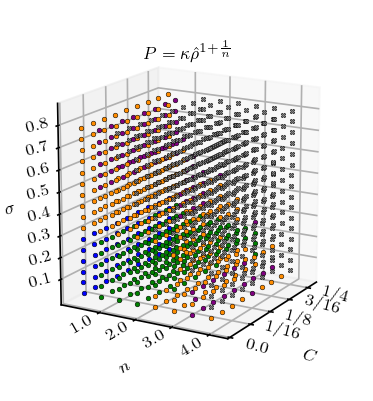

In [35]:
fig = plt.figure(figsize=(6,9),dpi=150)
# fig.suptitle(r'$P = \kappa$'.format(n),x=0.31,y=0.86,fontsize=8,zorder=7)

ax00 = fig.add_subplot(321, projection='3d',zorder=6)

ax00.scatter(C_List1,n_List1,sigma_List1,c='blue',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List2,n_List2,sigma_List2,c='green',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List3,n_List3,sigma_List3,c='darkorange',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List4,n_List4,sigma_List4,c='purple',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List7,n_List7,sigma_List7,c='gray',marker='X',s=5,depthshade=False,edgecolors='k',linewidths=0.25)

ax00.set_title(r'$P = \kappa \hat{\rho}^{1+\frac1n}$', x=0.5,y=0.925,fontsize=8,zorder=7)

ax00.xaxis.set_rotate_label(False)
ax00.yaxis.set_rotate_label(False)
ax00.zaxis.set_rotate_label(False)
ax00.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax00.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax00.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax00.set_xticks([0,1/16,1/8,3/16,1/4])
ax00.set_yticks([1.0,2.0,3.0,4.0])
ax00.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax00.grid(b=1)
ax00.set_xbound(0.0,1.1*max(Lista_C))
ax00.set_ybound(0.0,1.1*max(Lista_n))
ax00.set_zbound(0.0,1.1*max(Lista_sigma))
ax00.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax00.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax00.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax00.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax00.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax00.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax00.view_init(elev=-165, azim=150)
ax00.invert_xaxis()
ax00.invert_yaxis()
ax00.invert_zaxis()

legend_elements = [Line2D([0],[0],marker='o',color='w',label='9',markerfacecolor='red',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='8',markerfacecolor='blue',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='7',markerfacecolor='green',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='6',markerfacecolor='darkorange',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='5',markerfacecolor='purple',markersize=5),
                   Line2D([0],[0],marker='X',color='w',label='Sin borde',markerfacecolor='gray',markersize=5)]

# Legend = ax00.legend(handles=legend_elements,title=r'$N\acute{u}mero$ $de$ $condiciones$ $cumplidas$',ncol=6,
#                      loc=(-0.135,0.95),fontsize=6)
# plt.setp(Legend.get_title(),fontsize='small')

fig.subplots_adjust(wspace=0.075,hspace=-0.1)
plt.show()

In [11]:
legend_elements = [Line2D([0],[0],marker='o',color='w',label='9',markerfacecolor='red',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='8',markerfacecolor='blue',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='7',markerfacecolor='green',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='6',markerfacecolor='darkorange',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='5',markerfacecolor='purple',markersize=5)]

Legend = ax00.legend(handles=legend_elements,title=r'$N\acute{u}mero$ $de$ $condiciones$ $cumplidas$',ncol=6,
                     loc=(0.025,0.95),fontsize=6)
plt.setp(Legend.get_title(),fontsize='small')
plt.show()

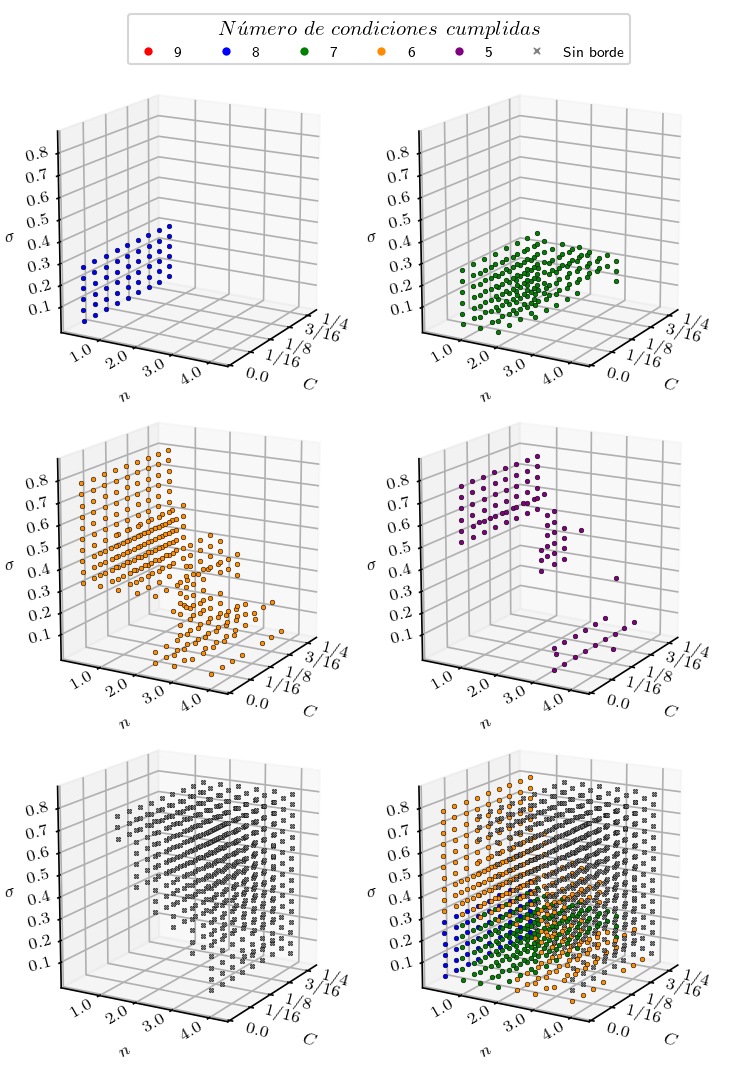

In [12]:
fig = plt.figure(figsize=(6,9),dpi=150)

ax00 = fig.add_subplot(321, projection='3d',zorder=6)
ax01 = fig.add_subplot(322, projection='3d',zorder=5)
ax10 = fig.add_subplot(323, projection='3d',zorder=4)
ax11 = fig.add_subplot(324, projection='3d',zorder=3)
ax20 = fig.add_subplot(325, projection='3d',zorder=2)
ax21 = fig.add_subplot(326, projection='3d',zorder=1)

ax00.scatter(C_List1,n_List1,sigma_List1,c='blue',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax01.scatter(C_List2,n_List2,sigma_List2,c='green',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax10.scatter(C_List3,n_List3,sigma_List3,c='darkorange',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax11.scatter(C_List4,n_List4,sigma_List4,c='purple',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax20.scatter(C_List7,n_List7,sigma_List7,c='gray',marker='X',s=5,depthshade=False,edgecolors='k',linewidths=0.25)

ax21.scatter(C_List1,n_List1,sigma_List1,c='blue',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax21.scatter(C_List2,n_List2,sigma_List2,c='green',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax21.scatter(C_List3,n_List3,sigma_List3,c='darkorange',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax21.scatter(C_List7,n_List7,sigma_List7,c='gray',marker='X',s=5,depthshade=False,edgecolors='k',linewidths=0.25)

ax00.xaxis.set_rotate_label(False)
ax00.yaxis.set_rotate_label(False)
ax00.zaxis.set_rotate_label(False)
ax00.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax00.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax00.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax00.set_xticks([0,1/16,1/8,3/16,1/4])
ax00.set_yticks([1.0,2.0,3.0,4.0])
ax00.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax00.grid(b=1)
ax00.set_xbound(0.0,1.1*max(Lista_C))
ax00.set_ybound(0.0,1.1*max(Lista_n))
ax00.set_zbound(0.0,1.1*max(Lista_sigma))
ax00.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax00.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax00.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax00.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax00.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax00.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax00.view_init(elev=-165, azim=150)

ax01.xaxis.set_rotate_label(False)
ax01.yaxis.set_rotate_label(False)
ax01.zaxis.set_rotate_label(False)
ax01.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax01.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax01.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax01.set_xticks([0,1/16,1/8,3/16,1/4])
ax01.set_yticks([1.0,2.0,3.0,4.0])
ax01.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax01.grid(b=True,)
ax01.set_xbound(0.0,1.1*max(Lista_C))
ax01.set_ybound(0.0,1.1*max(Lista_n))
ax01.set_zbound(0.0,1.1*max(Lista_sigma))
ax01.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax01.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax01.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax01.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax01.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax01.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax01.view_init(elev=-165, azim=150)

ax10.xaxis.set_rotate_label(False)
ax10.yaxis.set_rotate_label(False)
ax10.zaxis.set_rotate_label(False)
ax10.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax10.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax10.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax10.set_xticks([0,1/16,1/8,3/16,1/4])
ax10.set_yticks([1.0,2.0,3.0,4.0])
ax10.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax10.grid(b=True,)
ax10.set_xbound(0.0,1.1*max(Lista_C))
ax10.set_ybound(0.0,1.1*max(Lista_n))
ax10.set_zbound(0.0,1.1*max(Lista_sigma))
ax10.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax10.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax10.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax10.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax10.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax10.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax10.view_init(elev=-165, azim=150)

ax11.xaxis.set_rotate_label(False)
ax11.yaxis.set_rotate_label(False)
ax11.zaxis.set_rotate_label(False)
ax11.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax11.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax11.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax11.set_xticks([0,1/16,1/8,3/16,1/4])
ax11.set_yticks([1.0,2.0,3.0,4.0])
ax11.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax11.grid(b=True,)
ax11.set_xbound(0.0,1.1*max(Lista_C))
ax11.set_ybound(0.0,1.1*max(Lista_n))
ax11.set_zbound(0.0,1.1*max(Lista_sigma))
ax11.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax11.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax11.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax11.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax11.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax11.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax11.view_init(elev=-165, azim=150)

ax20.xaxis.set_rotate_label(False)
ax20.yaxis.set_rotate_label(False)
ax20.zaxis.set_rotate_label(False)
ax20.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax20.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax20.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax20.set_xticks([0,1/16,1/8,3/16,1/4])
ax20.set_yticks([1.0,2.0,3.0,4.0])
ax20.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax20.grid(b=True,)
ax20.set_xbound(0.0,1.1*max(Lista_C))
ax20.set_ybound(0.0,1.1*max(Lista_n))
ax20.set_zbound(0.0,1.1*max(Lista_sigma))
ax20.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax20.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax20.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax20.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax20.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax20.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax20.view_init(elev=-165, azim=150)

ax21.xaxis.set_rotate_label(False)
ax21.yaxis.set_rotate_label(False)
ax21.zaxis.set_rotate_label(False)
ax21.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax21.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax21.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax21.set_xticks([0,1/16,1/8,3/16,1/4])
ax21.set_yticks([1.0,2.0,3.0,4.0])
ax21.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax21.grid(b=True,)
ax21.set_xbound(0.0,1.1*max(Lista_C))
ax21.set_ybound(0.0,1.1*max(Lista_n))
ax21.set_zbound(0.0,1.1*max(Lista_sigma))
ax21.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax21.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax21.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax21.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax21.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax21.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax21.view_init(elev=-165, azim=150)

ax00.invert_xaxis()
ax00.invert_yaxis()
ax00.invert_zaxis()

ax01.invert_xaxis()
ax01.invert_yaxis()
ax01.invert_zaxis()

ax10.invert_xaxis()
ax10.invert_yaxis()
ax10.invert_zaxis()

ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.invert_zaxis()

ax20.invert_xaxis()
ax20.invert_yaxis()
ax20.invert_zaxis()

ax21.invert_xaxis()
ax21.invert_yaxis()
ax21.invert_zaxis()

legend_elements = [Line2D([0],[0],marker='o',color='w',label='9',markerfacecolor='red',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='8',markerfacecolor='blue',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='7',markerfacecolor='green',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='6',markerfacecolor='darkorange',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='5',markerfacecolor='purple',markersize=5),
                   Line2D([0],[0],marker='X',color='w',label='Sin borde',markerfacecolor='gray',markersize=5)]

Legend = ax00.legend(handles=legend_elements,title=r'$N\acute{u}mero$ $de$ $condiciones$ $cumplidas$',ncol=6,
                     loc=(0.325,0.95),fontsize=7)
plt.setp(Legend.get_title(),fontsize='medium')


fig.subplots_adjust(wspace=0.075,hspace=-0.1)
plt.show()

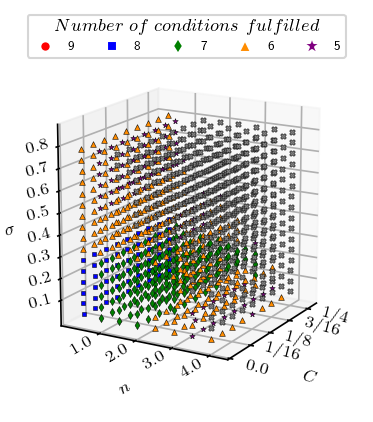

In [13]:
fig = plt.figure(figsize=(6,9),dpi=150)

ax00 = fig.add_subplot(321, projection='3d',zorder=6)

ax00.scatter(C_List1,n_List1,sigma_List1,c='blue',marker='s',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List2,n_List2,sigma_List2,c='green',marker='d',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List3,n_List3,sigma_List3,c='darkorange',marker='^',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List4,n_List4,sigma_List4,c='purple',marker='*',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(C_List7,n_List7,sigma_List7,c='gray',marker='X',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)


ax00.xaxis.set_rotate_label(False)
ax00.yaxis.set_rotate_label(False)
ax00.zaxis.set_rotate_label(False)
ax00.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax00.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax00.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax00.set_xticks([0,1/16,1/8,3/16,1/4])
ax00.set_yticks([1.0,2.0,3.0,4.0])
ax00.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax00.grid(b=1)
ax00.set_xbound(0.0,1.1*max(Lista_C))
ax00.set_ybound(0.0,1.1*max(Lista_n))
ax00.set_zbound(0.0,1.1*max(Lista_sigma))
ax00.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax00.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax00.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax00.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax00.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax00.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax00.view_init(elev=-165, azim=150)
ax00.invert_xaxis()
ax00.invert_yaxis()
ax00.invert_zaxis()

legend_elements = [Line2D([0],[0],marker='o',color='w',label='9',markerfacecolor='red',markersize=5),
                   Line2D([0],[0],marker='s',color='w',label='8',markerfacecolor='blue',markersize=5),
                   Line2D([0],[0],marker='d',color='w',label='7',markerfacecolor='green',markersize=5.5),
                   Line2D([0],[0],marker='^',color='w',label='6',markerfacecolor='darkorange',markersize=6),
                   Line2D([0],[0],marker='*',color='w',label='5',markerfacecolor='purple',markersize=9)]

Legend = ax00.legend(handles=legend_elements,title=r'$Number\ of\ conditions\ fulfilled$',ncol=6,
                     loc=(0.0275,0.95),fontsize=6)
plt.setp(Legend.get_title(),fontsize='small')

fig.subplots_adjust(wspace=0.075,hspace=-0.1)
plt.show()